
## **<font color='White Gray'>Data Science for Multivariate Data Analysis</font>**
### **<font color='White Gray'>Data Science in Marketing - Customer Base Segmentation</font>**


## **Installing and Loading the Packages**

In [183]:
# To update a package, run the command below in the terminal or command prompt:
# pip install -U package_name

# To install a specific version of a package, run the command below in the terminal or command prompt:
# !pip install package_name==desired_version

# After installing or updating the package, restart the Jupyter Notebook.

# Installs the watermark package.
# This package is used to record the versions of other packages used in this Jupyter Notebook.
!pip install -q -U watermark

In [184]:
# Prerequisite for K-Means
!pip install -q threadpoolctl==3.1.0

In [185]:
# Imports
import threadpoolctl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [186]:
# Versions of the packages used in this Jupyter Notebook
%reload_ext watermark
%watermark -a "@panData"

Author: @panData



## **Loading and Exploring the Data**

In [187]:
# Set seed
np.random.seed(42)

In [188]:
# Load the dataset
df = pd.read_csv('dataset.csv')

In [189]:
# Shape
df.shape

(99, 6)

In [190]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    99 non-null     int64  
 1   Monthly_Spending       99 non-null     float64
 2   Subscription_Duration  99 non-null     int64  
 3   Usage_Rate             99 non-null     float64
 4   Support_Tickets        99 non-null     int64  
 5   Cancelled              99 non-null     int64  
dtypes: float64(2), int64(4)
memory usage: 4.8 KB


In [191]:
# First rows
df.head()

,Age,Monthly_Spending,Subscription_Duration,Usage_Rate,Support_Tickets,Cancelled
0,48,529.152948,13,0.524262,2,1
1,37,684.502168,13,0.628494,2,0
2,31,797.016155,17,0.706550,1,0
3,30,542.025205,12,0.517458,3,0
4,44,655.498896,15,0.774564,3,0


In [192]:
df.sample(10)

,Age,Monthly_Spending,Subscription_Duration,Usage_Rate,Support_Tickets,Cancelled
62,38,739.488554,15,0.547594,3,0
40,24,218.509402,1,0.422976,1,0
95,53,999.943535,23,0.865750,5,1
18,28,172.894435,3,0.110168,1,0
97,61,911.086341,22,0.848029,2,1
84,56,918.826143,21,0.879309,2,1
64,46,710.590063,16,0.602564,1,1
42,31,106.254563,5,0.227201,1,0
10,32,588.077553,16,0.691481,0,1
0,48,529.152948,13,0.524262,2,1


## **Exploratory Data Analysis and Data Cleaning**

In [193]:
# Checking for null values
print(df.isnull().sum())

Age                      0
Monthly_Spending         0
Subscription_Duration    0
Usage_Rate               0
Support_Tickets          0
Cancelled                0
dtype: int64


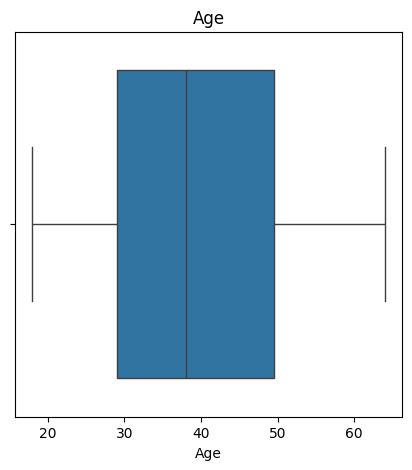

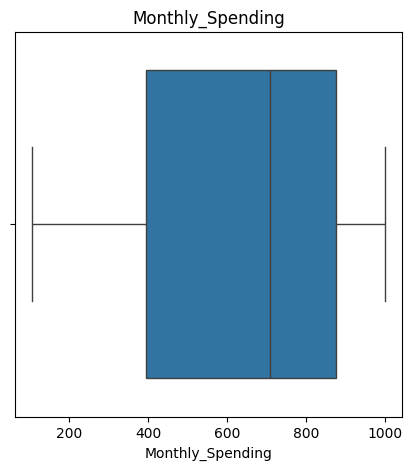

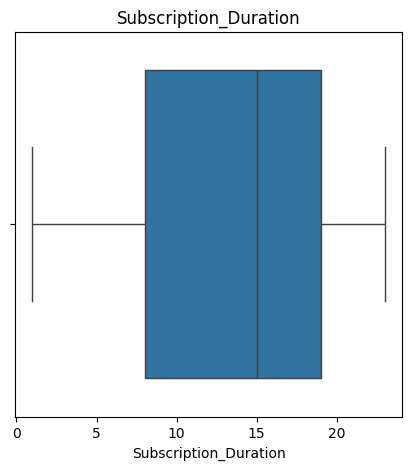

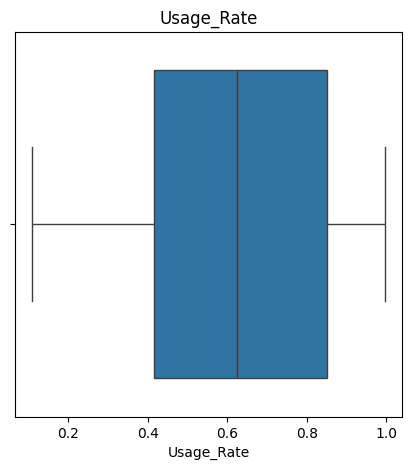

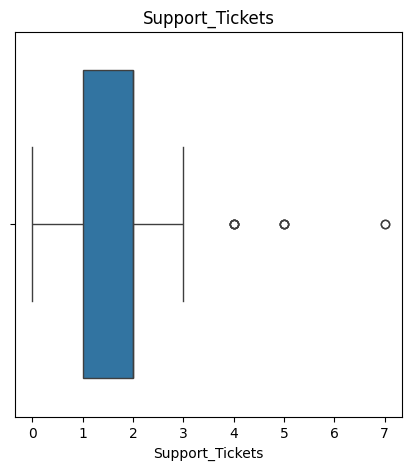

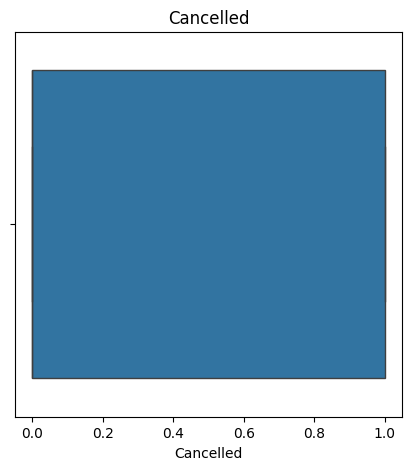

In [194]:
# Visualizing outliers for each variable in the DataFrame
for column in df.columns:
    if df[column].dtype in ['int64', 'float64']:
        plt.figure(figsize = (5, 5))
        sns.boxplot(x = df[column])
        plt.title(column)
        plt.show()

In [195]:
# Number of records per category of the variable
df['Cancelled'].value_counts()

,count
Cancelled,
0,50
1,49


In [196]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,99.0,39.888889,13.089869,18.000000,29.000000,38.000000,49.500000,64.000000
Monthly_Spending,99.0,639.071009,270.618268,106.254563,394.918421,709.104722,875.735422,999.943535
Subscription_Duration,99.0,13.646465,6.599804,1.000000,8.000000,15.000000,19.000000,23.000000
Usage_Rate,99.0,0.604374,0.263824,0.110168,0.414928,0.623406,0.849839,0.996007
Support_Tickets,99.0,1.747475,1.486974,0.000000,1.000000,2.000000,2.000000,7.000000
Cancelled,99.0,0.494949,0.502519,0.000000,0.000000,0.000000,1.000000,1.000000


The KMeans algorithm uses Euclidean distance between points to form clusters. Euclidean distance is a measure of how far apart two points are in Euclidean space, which is the common space we use in everyday life. Imagine you have two points on a piece of paper or on a map. The Euclidean distance is the measure of the shortest length between these two points, as if you were using a straight ruler to connect them. It's the most direct and common way to measure the distance between two points in a two-dimensional or three-dimensional space. If you think of two points on a straight line, the Euclidean distance is simply the difference between them. In a two-dimensional space, like a plane, it's like measuring the hypotenuse of a right triangle formed by the two points and their projections along the axes. In three dimensions, it's like measuring the straight line between two points in space.

And the calculation of distance will be affected by outlier values.

In [197]:
# Define the Interquartile Range
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Age                       20.500000
Monthly_Spending         480.817001
Subscription_Duration     11.000000
Usage_Rate                 0.434911
Support_Tickets            1.000000
Cancelled                  1.000000
dtype: float64


In [198]:
# Let's check the values that are 1.5 above or below the IQR. These values are considered outliers.
outliers = ((df < (Q1 - 2.5 * IQR)) | (df > (Q3 + 2.5 * IQR))).any(axis = 1)

In [199]:
# Filter out the outliers
df_outliers = df[outliers]

In [200]:
# Visualizamos os outliers
df_outliers

,Age,Monthly_Spending,Subscription_Duration,Usage_Rate,Support_Tickets,Cancelled
12,46,743.034018,16,0.697133,5,0
53,48,550.847824,12,0.619646,7,1
54,43,667.040379,13,0.630056,5,0
63,34,694.989179,17,0.536049,7,1
95,53,999.943535,23,0.865750,5,1
96,48,999.327367,21,0.926680,5,1


In [201]:
# Calculating the correlation matrix
correlation_matrix = df.corr()
correlation_matrix

,Age,Monthly_Spending,Subscription_Duration,Usage_Rate,Support_Tickets,Cancelled
Age,1.000000,0.856041,0.814066,0.846363,0.431047,0.624298
Monthly_Spending,0.856041,1.000000,0.914275,0.912730,0.378802,0.651229
Subscription_Duration,0.814066,0.914275,1.000000,0.891799,0.427516,0.687107
Usage_Rate,0.846363,0.912730,0.891799,1.000000,0.380526,0.643879
Support_Tickets,0.431047,0.378802,0.427516,0.380526,1.000000,0.278220
Cancelled,0.624298,0.651229,0.687107,0.643879,0.278220,1.000000


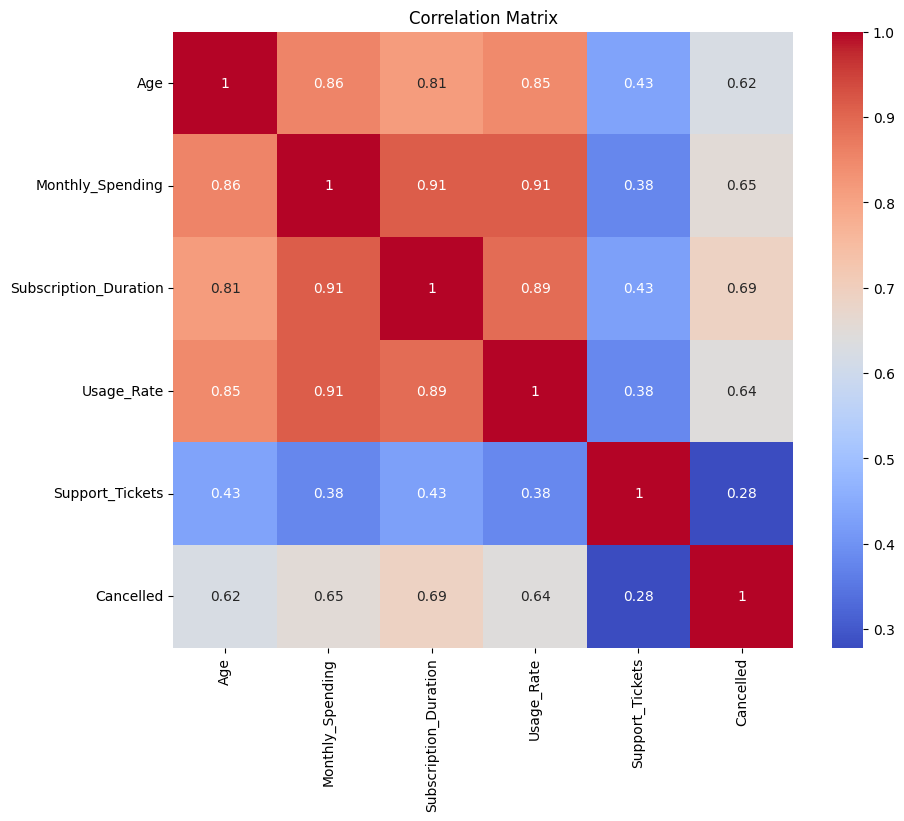

In [202]:
# Plot
plt.figure(figsize = (10,8))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm')
plt.title('Correlation Matrix')
plt.show()

Correlation can have a significant impact on clustering models like KMeans, as KMeans uses Euclidean distance between points to form clusters. Highly correlated variables can disproportionately influence the distances between points, leading to potential distortions in the clusters formed. We need to consider the following points:

Multicollinearity:
If two variables are highly correlated (multicollinearity), this can result in redundancy and may not add value to the model, potentially harming cluster formation. You can remove one variable when it is highly correlated with another.
Variable Scale:
Correlation can also indicate the need to normalize variables, especially when dealing with variables on different scales, since KMeans is sensitive to the scale of variables.
Dimensionality Reduction:
Correlation analysis can be a preliminary step to applying dimensionality reduction techniques like PCA (Principal Component Analysis), which can be useful to mitigate multicollinearity issues and to speed up the clustering process when dealing with a large number of variables.

Therefore, before applying KMeans, it's generally advisable to take the following steps based on correlation analysis:

Remove or combine highly correlated variables to reduce multicollinearity.
Normalize or standardize variables to ensure they are on the same scale.
Consider dimensionality reduction if the dataset has a large number of variables.

Correlation can have a significant impact on clustering models like KMeans, as KMeans uses Euclidean distance between points to form clusters. Highly correlated variables can disproportionately influence the distances between points, leading to potential distortions in the clusters formed.

We need to consider the following points:

Multicollinearity:
If two variables are highly correlated (multicollinearity), this can result in redundancy and may not add value to the model, potentially harming cluster formation. You can remove one variable when it is highly correlated with another.
Scale of Variables:
Correlation can also be an indicator of the need to normalize variables, especially when dealing with variables on different scales, since KMeans is sensitive to the scale of variables.
Dimensionality Reduction:
Correlation analysis can be a preliminary step to applying techniques like PCA (Principal Component Analysis), which can be useful for mitigating multicollinearity issues and speeding up the clustering process when there's a large number of variables.

Therefore, before applying KMeans, it's generally advisable to take the following steps based on correlation analysis:

Remove or combine highly correlated variables to reduce multicollinearity.
Normalize or standardize variables to ensure they are on the same scale.
Consider dimensionality reduction if the dataset has a large number of variables.

In [203]:
# Create the standardizer
scaler = StandardScaler()

In [204]:
# Standardizing the Variables
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

In [205]:
df_scaled.head()

,Age,Monthly_Spending,Subscription_Duration,Usage_Rate,Support_Tickets,Cancelled
0,0.622801,-0.408241,-0.098451,-0.305201,0.170689,1.010153
1,-0.221820,0.168733,-0.098451,0.091893,0.170689,-0.989949
2,-0.682522,0.586616,0.510712,0.389261,-0.505240,-0.989949
3,-0.759306,-0.360433,-0.250741,-0.331122,0.846619,-0.989949
4,0.315666,0.061014,0.206131,0.648375,0.846619,-0.989949


In [206]:
df.head()

,Age,Monthly_Spending,Subscription_Duration,Usage_Rate,Support_Tickets,Cancelled
0,48,529.152948,13,0.524262,2,1
1,37,684.502168,13,0.628494,2,0
2,31,797.016155,17,0.706550,1,0
3,30,542.025205,12,0.517458,3,0
4,44,655.498896,15,0.774564,3,0


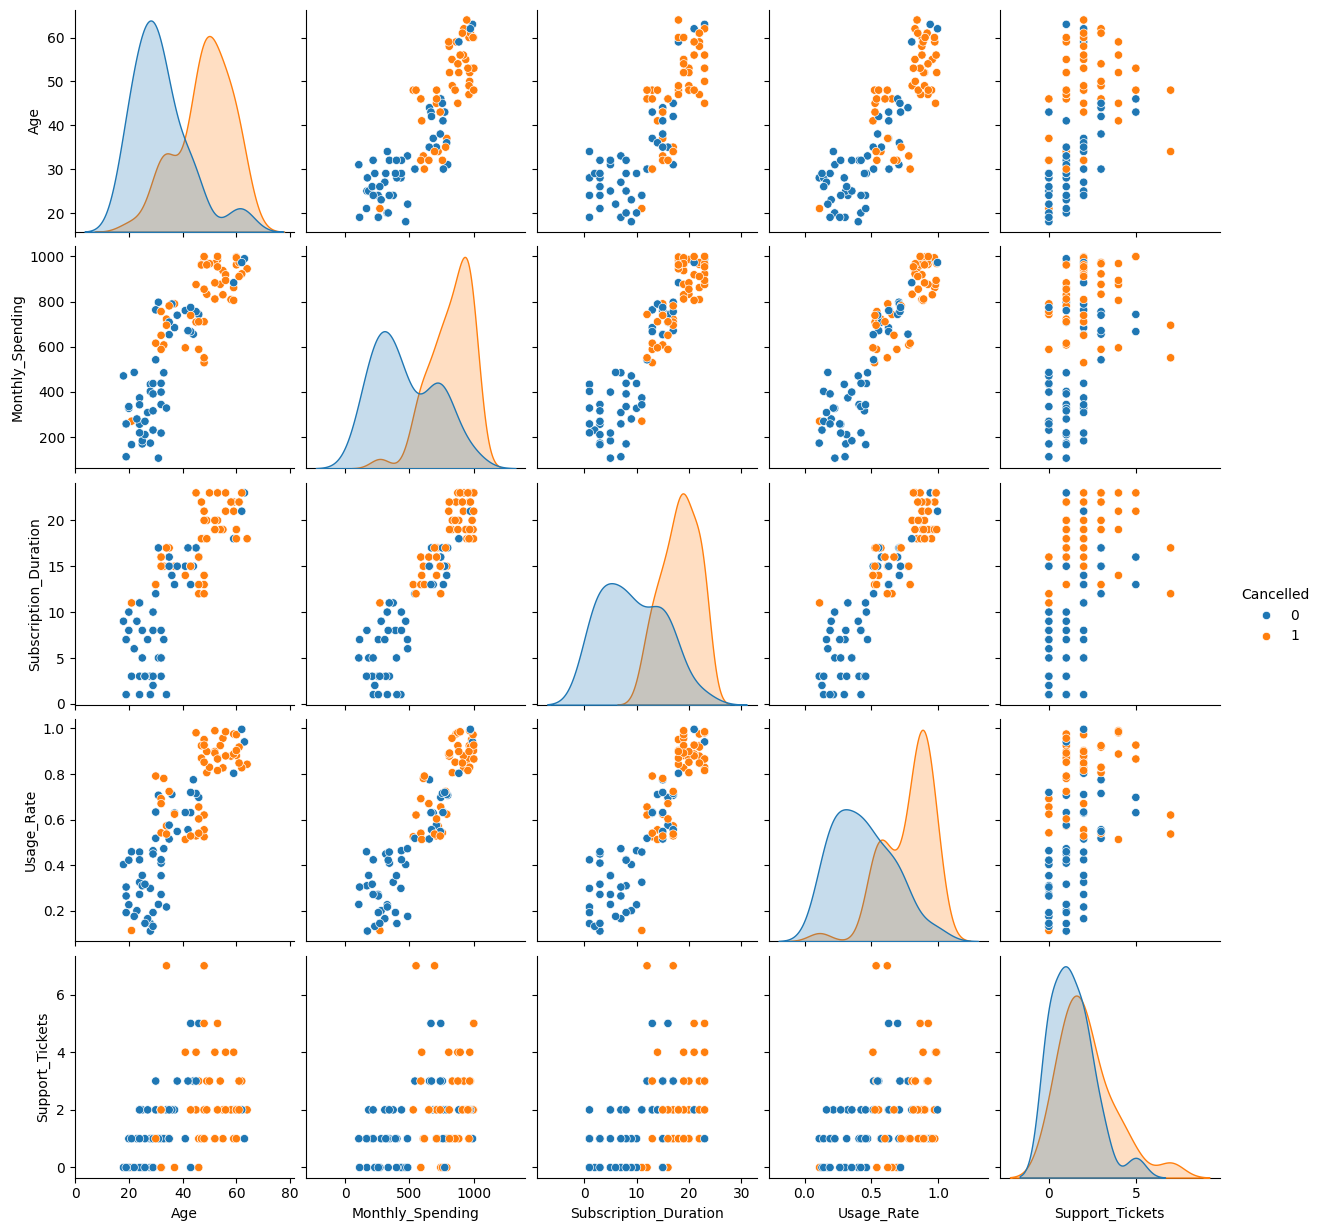

In [207]:
# Data Visualization using PairPlot
sns.pairplot(df, hue='Cancelled', diag_kind='kde')
plt.show()

## **Defining the Value of K in Clustering Models**
The KMeans algorithm is a data clustering technique that organizes a set of points into groups (or "clusters") based on their similarities. Imagine you have several points scattered in a space and you want to group them into sets that are similar to each other. KMeans does this in the following way:

Initial Choice: First, you decide how many groups (K) you want to create. Then, you randomly choose K points in the space as the initial centers of these groups. These points are called centroids.

Group Assignment: Next, for each point in the dataset, the algorithm finds which of the centroids is closest and assigns that point to the group corresponding to that centroid.

Centroid Update: After all points have been assigned to a group, the algorithm recalculates the center of each group. The new centroid of each group is the average of all points that were assigned to that group.

Repetition: The process of group assignment and centroid update is repeated several times until the centroids stop moving significantly. This means that the groups are no longer changing, and the algorithm has found a good organization of the points into clusters.

The result is a division of the dataset into K groups, where the points within each group are more similar to each other than to points in other groups.

The value of k in clustering methods like K-Means refers to the number of clusters that the algorithm should form.

Choosing the right value for k is a critical step in the work we're doing, as it can significantly impact the usefulness of the clusters formed.

Below are some methods that can be used to select the value of k. However, ALWAYS use common sense first when deciding the number of clusters.

### **Elbow Method**
The Elbow Method is one of the most common approaches to finding the optimal value of k. It involves running the clustering algorithm for different values of k and calculating the Sum of Squared Errors (SSE) for each value of k. The value of k where the reduction in SSE begins to slow down (the "elbow" of the curve) is considered the optimal k.

### **Understanding the Sum of Squared Errors (SSE)**

The Sum of Squared Errors (SSE) is a measure that indicates how compact the clusters are in a clustering algorithm like K-Means. It’s a way to assess the quality of the clusters by quantifying how close the points within each cluster are to that cluster's centroid.

Imagine that each cluster is a circle and the points inside that circle are the cluster elements. The center of this circle is the centroid, which is the average of all the points in the cluster. SSE measures the sum of the squared distances from each point to the centroid of its respective cluster. For each point, the distance to the centroid is calculated, squared, and then all these values are summed.

The lower the SSE, the closer the points are to their centroids, indicating that the clusters are more compact and well-defined. A large SSE, on the other hand, suggests that the points are more dispersed around the centroids, indicating that the clusters may not be as well-defined.

In [208]:
# List to store the SSE
sse = []

In [209]:
# Range of k values to be tested
k_range = range(1, 11)

In [210]:
# Testing the values
for k in k_range:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(df_scaled)
    sse.append(kmeans.inertia_)

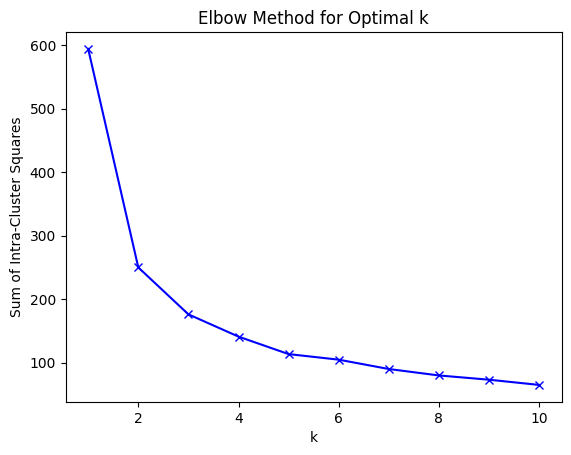

In [211]:
# Plot
plt.plot(k_range, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Intra-Cluster Squares')
plt.title('Elbow Method for Optimal k')
plt.show()

### **Silhouette Method**

The Silhouette Method is a technique used to assess the quality of the clusters formed by a clustering algorithm like KMeans. It provides a measure of how well a point has been clustered and whether it is in the correct cluster.

The calculation of the Silhouette for a point involves two distances:

Cohesion (a): The average distance between the point and all other points within the same cluster. The smaller this value, the closer the point is to the other points in its cluster, indicating good cohesion.

Separation (b): The smallest average distance between the point and points in a different cluster. The larger this value, the farther the point is from the points in other clusters, indicating good separation.

The value of s ranges from -1 to 1:

- A value close to 1 indicates that the point is well-clustered within its cluster and far from other clusters.
- A value close to 0 indicates that the point is near the boundary between two clusters.
- A value close to -1 indicates that the point may have been misclassified into the wrong cluster.


The average Silhouette score for all points in the dataset can be used as an overall measure of clustering quality. The closer this average value is to 1, the better the quality of the formed clusters. The Silhouette Method is useful for determining the optimal number of clusters in a dataset, as you can run the clustering algorithm with different numbers of clusters and select the one that results in the highest average Silhouette score.

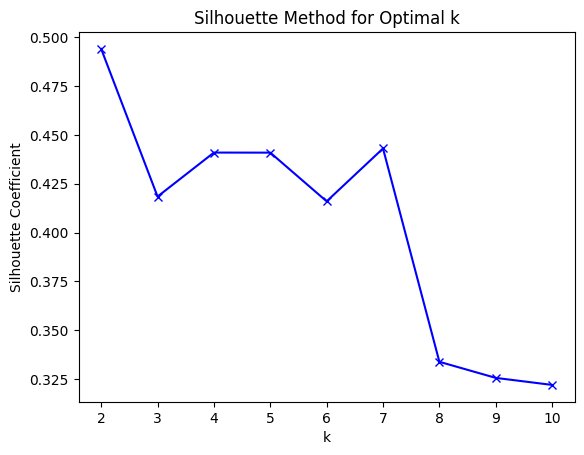

In [212]:
# List to store Silhouette score
sil_score = []

# Loop through the range of k values to be tested
for k in k_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_scaled)

    # Silhouette score is not defined for k = 1, so we filter it out
    if k != 1:
        sil_score.append(silhouette_score(df_scaled, kmeans.labels_))

# Plot
plt.plot(k_range[1:], sil_score, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Method for Optimal k')
plt.show()


## **Construction of the First Version of the Clustering Model**

In [213]:
# Creating the model with 4 clusters
modelo_kmeans = KMeans(n_clusters=4, random_state=42)

In [214]:
# Fitting the model to the scaled data
df['cluster'] = modelo_kmeans.fit_predict(df_scaled)

In [215]:
# Displaying a sample of the data with the new cluster labels
df.sample(5)

,Age,Monthly_Spending,Subscription_Duration,Usage_Rate,Support_Tickets,Cancelled,cluster
85,54,876.178171,19,0.924417,3,1,0
33,32,437.813539,8,0.423248,2,0,1
98,53,953.797483,23,0.815173,2,1,0
15,28,433.277965,1,0.297518,0,0,1
48,32,755.902837,15,0.541506,0,1,3


In [216]:
# Using the original dataset, including outliers
df_cleaned = df

> Vamos criar um PairGrid.

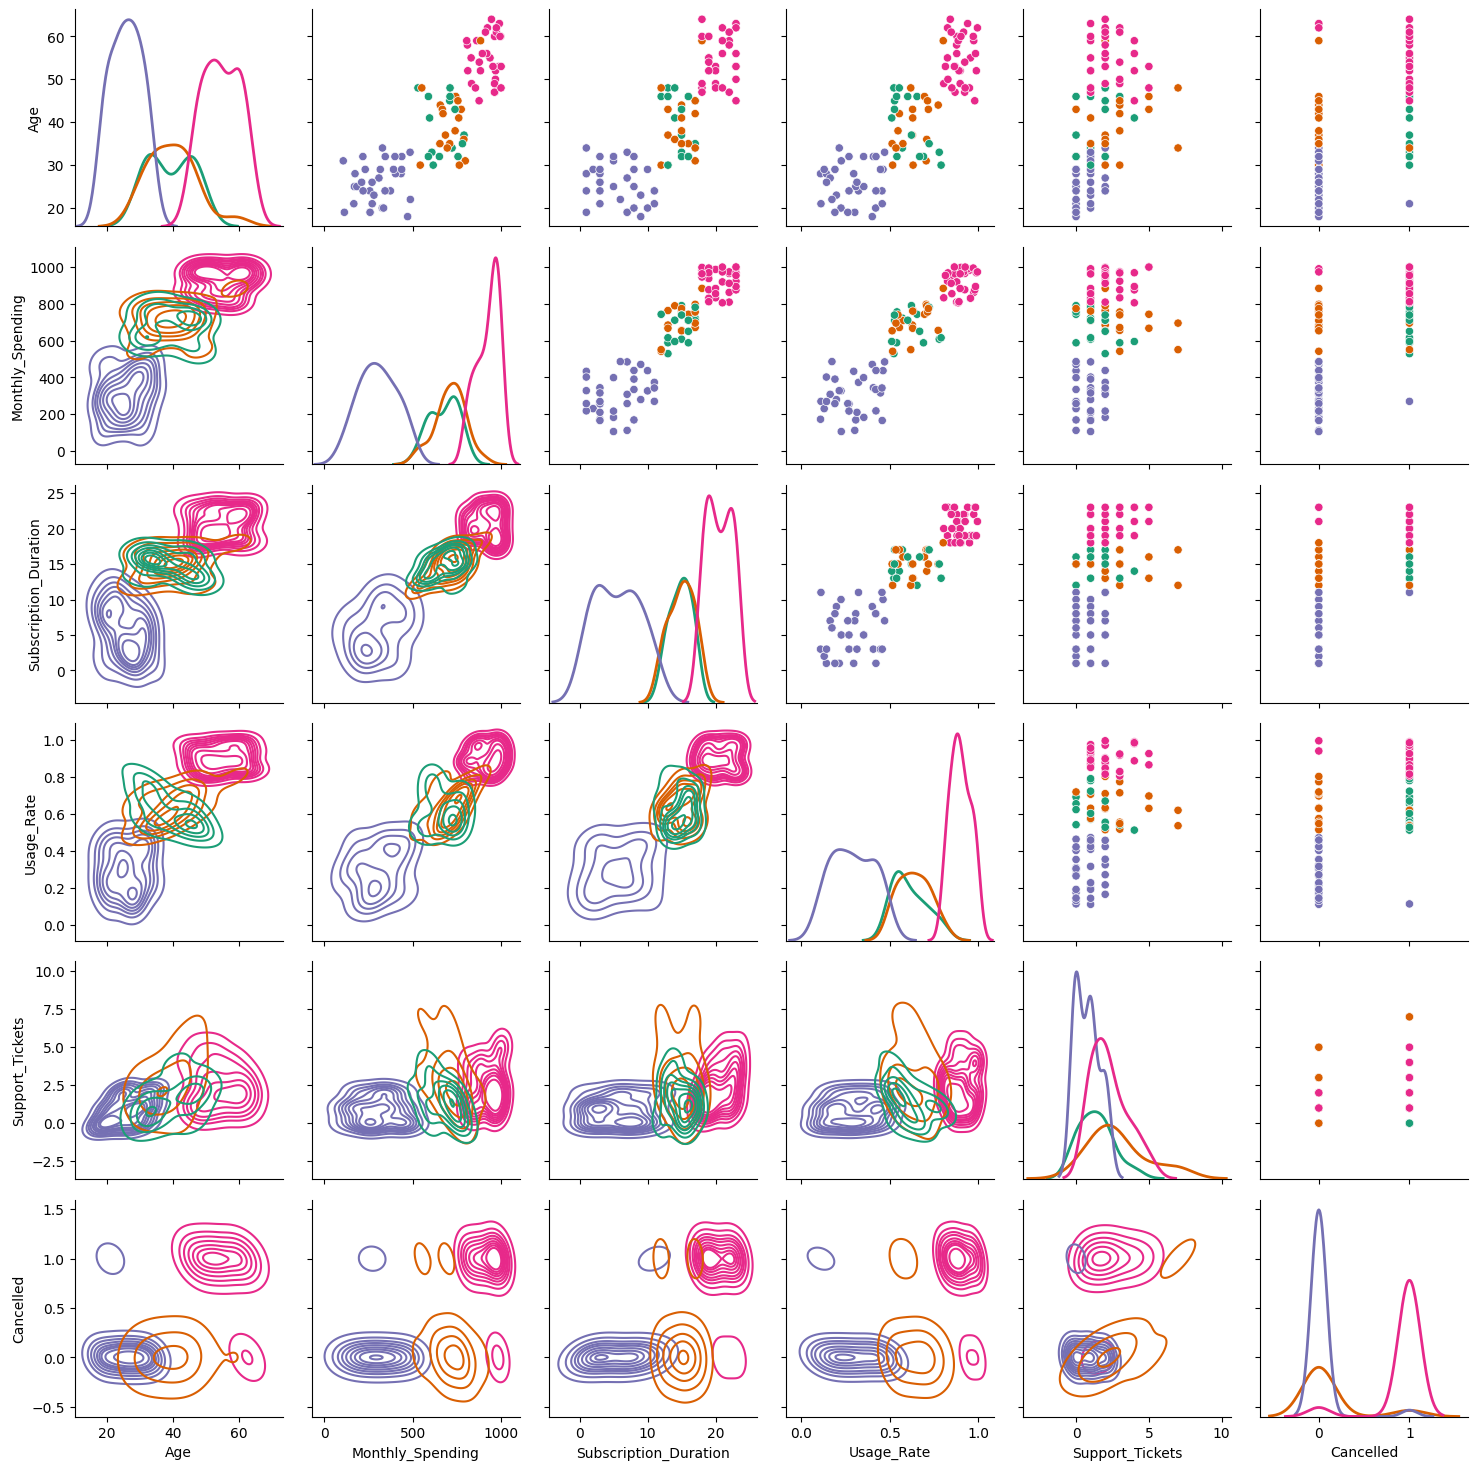

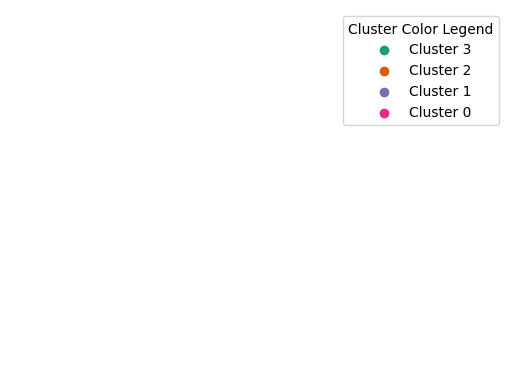

In [217]:
# Creating a color map based on the 'Dark2' palette
palette = sns.color_palette('Dark2', n_colors = len(df_cleaned['cluster'].unique()))
color_map = dict(zip(df_cleaned['cluster'].unique(), palette))

# Plotting the grid chart with clusters and showing the color map
g = sns.PairGrid(df_cleaned, hue = 'cluster', palette = color_map, diag_sharey = False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw = 2)
plt.show()

# Displaying the color map
for cluster, color in color_map.items():
    plt.scatter([], [], c = [color], label = f'Cluster {cluster}')
plt.legend(title = 'Cluster Color Legend')
plt.axis('off')
plt.show()

## **Building the Second Version of the Clustering Model**
In this step, we will create the second version of our clustering model. The first version used K=4 clusters, but after analyzing the results, we identified some overlap between clusters. Now, we will reduce the number of clusters to K=3 and test again.

In [218]:
# Model with 3 clusters
model_kmeans = KMeans(n_clusters = 3, random_state = 42)

In [219]:
# Drop the previous cluster column
df.drop('cluster', axis = 1, inplace = True)

In [220]:
# Display the first rows
df.head()

,Age,Monthly_Spending,Subscription_Duration,Usage_Rate,Support_Tickets,Cancelled
0,48,529.152948,13,0.524262,2,1
1,37,684.502168,13,0.628494,2,0
2,31,797.016155,17,0.706550,1,0
3,30,542.025205,12,0.517458,3,0
4,44,655.498896,15,0.774564,3,0


In [221]:
# Train the model and save the result in a column of the original dataframe
df['cluster'] = model_kmeans.fit_predict(df_scaled)

In [222]:
# Random sample of data
df.sample(10)

,Age,Monthly_Spending,Subscription_Duration,Usage_Rate,Support_Tickets,Cancelled,cluster
5,30,763.211922,13,0.632706,2,0,2
13,24,373.305408,11,0.324511,2,0,0
69,49,832.523388,20,0.805757,3,1,1
84,56,918.826143,21,0.879309,2,1,1
74,62,922.683039,23,0.827274,3,1,1
72,63,989.959983,23,0.940816,1,0,1
65,43,738.737801,15,0.527540,2,1,2
95,53,999.943535,23,0.865750,5,1,1
32,33,484.468810,7,0.471879,1,0,0
58,41,760.121696,15,0.630702,1,0,2


In [223]:
# Keep only the rows that are not outliers
df_cleaned = df[~outliers]

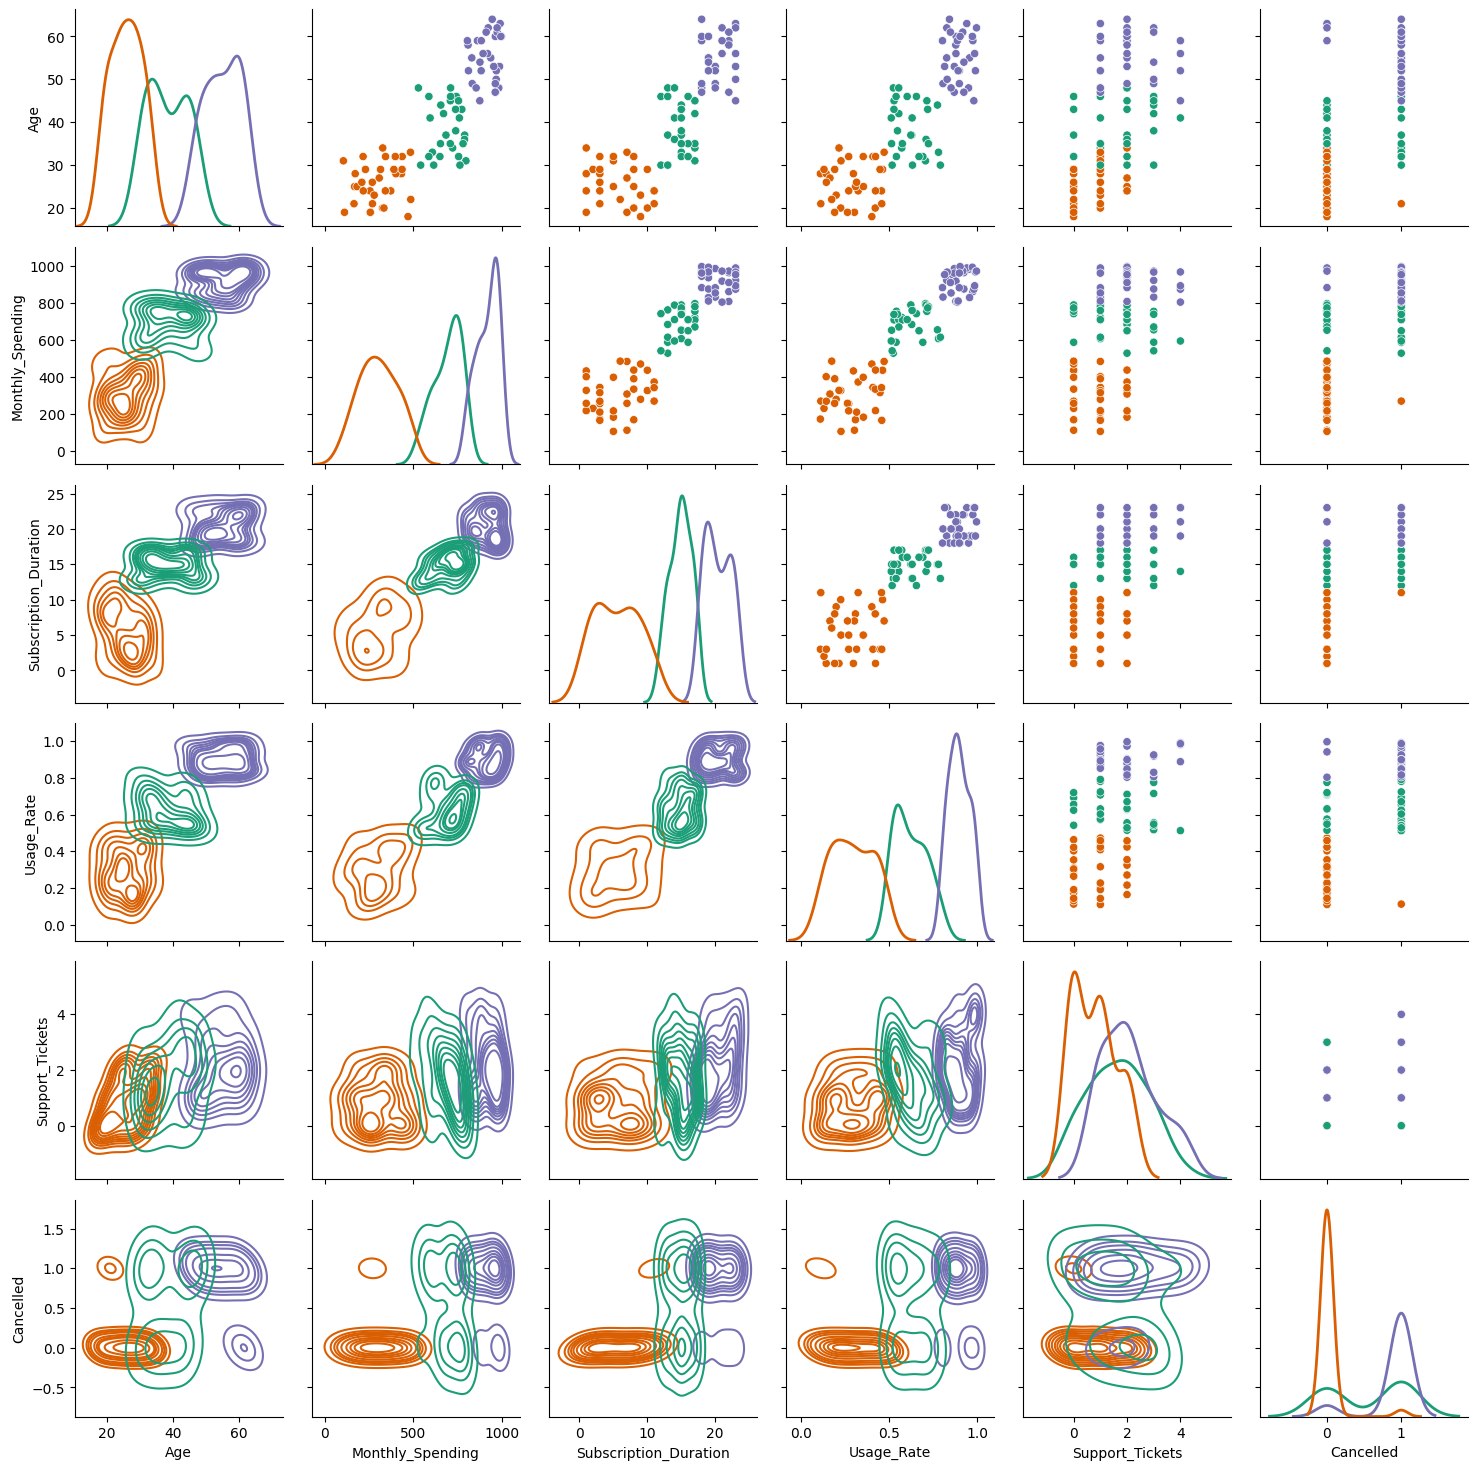

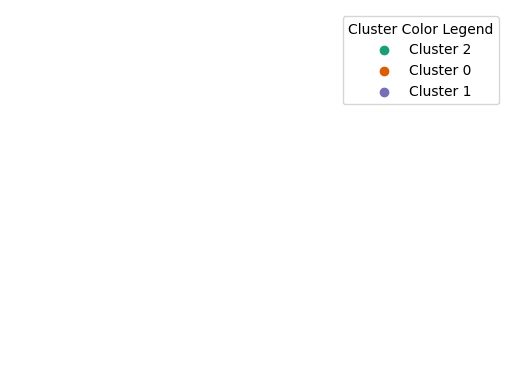

In [224]:
# Creating a color map based on the 'Dark2' palette
palette = sns.color_palette('Dark2', n_colors = len(df_cleaned['cluster'].unique()))
color_map = dict(zip(df_cleaned['cluster'].unique(), palette))

# Plotting the grid chart with clusters and showing the color map
g = sns.PairGrid(df_cleaned, hue = 'cluster', palette = color_map, diag_sharey = False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw = 2)
plt.show()

# Displaying the color map
for cluster, color in color_map.items():
    plt.scatter([], [], c = [color], label = f'Cluster {cluster}')
plt.legend(title = 'Cluster Color Legend')
plt.axis('off')
plt.show()

Analyzing the charts, we can identify segmentations among users who canceled their subscriptions. Evaluate the patterns, distributions, and overlaps between the clusters. Make interpretations based on the groupings, investigating the predominant characteristics in each cluster and how they might be associated with subscription cancellation.

After the interpretation, summarize the key findings and propose strategic recommendations based on the insights obtained, such as targeted retention strategies for each identified segment.

## **Analyzing the Clusters of the Chosen Model**

In [225]:
df_cleaned.head(5)

,Age,Monthly_Spending,Subscription_Duration,Usage_Rate,Support_Tickets,Cancelled,cluster
0,48,529.152948,13,0.524262,2,1,2
1,37,684.502168,13,0.628494,2,0,2
2,31,797.016155,17,0.706550,1,0,2
3,30,542.025205,12,0.517458,3,0,2
4,44,655.498896,15,0.774564,3,0,2


In [226]:
df_cleaned.sample(5)

,Age,Monthly_Spending,Subscription_Duration,Usage_Rate,Support_Tickets,Cancelled,cluster
46,37,789.996446,15,0.623406,0,1,2
40,24,218.509402,1,0.422976,1,0,0
47,36,789.085993,14,0.709854,2,0,2
67,60,962.759004,19,0.880697,1,1,1
41,21,166.106776,3,0.458437,1,0,0


In [227]:
df_cleaned[df_cleaned.cluster == 0].head()
df_cleaned[df_cleaned.cluster == 0].mean()

,0
Age,25.848485
Monthly_Spending,302.863443
Subscription_Duration,5.606061
Usage_Rate,0.293108
Support_Tickets,0.787879
Cancelled,0.030303
cluster,0.000000


In [228]:
df_cleaned[df_cleaned.cluster == 1].head()
df_cleaned[df_cleaned.cluster == 1].mean()

,0
Age,55.129032
Monthly_Spending,919.013690
Subscription_Duration,20.387097
Usage_Rate,0.897477
Support_Tickets,2.096774
Cancelled,0.903226
cluster,1.000000


In [229]:
df_cleaned[df_cleaned.cluster == 2].head()
df_cleaned[df_cleaned.cluster == 2].mean()

,0
Age,38.448276
Monthly_Spending,694.101019
Subscription_Duration,14.896552
Usage_Rate,0.622873
Support_Tickets,1.655172
Cancelled,0.551724
cluster,2.000000


### **Cluster Centroids**
First, you can examine the centroids of each cluster to identify which characteristics are predominant in each group.

In [230]:
# Extract the centroids
centroids = model_kmeans.cluster_centers_

The output below refers to the centroids of the clusters found by the KMeans algorithm. The centroids are the central points of each cluster and are used by the algorithm to determine which cluster a particular observation belongs to, based on the shortest Euclidean distance.

Given the output, we have 3 clusters (because there are 3 rows of numbers), and each cluster has 6 features (because there are 6 numbers in each row).

In [231]:
print(centroids)

[[-1.07807472 -1.24869086 -1.22447918 -1.1858289  -0.64861907 -0.92934034]
 [ 1.14865372  1.05786786  1.04142262  1.11634458  0.35503359  0.82832509]
 [-0.07057899  0.19082299  0.18305656  0.06948432  0.29358547  0.10101525]]


**Interpretation:**

- Cluster 0 (first row): This cluster mostly contains customers from the group that did not cancel their subscription. The values are negative and below -1 for most dimensions, indicating that the observations in this cluster have values below the average for these dimensions.

- Cluster 1 (second row): This cluster mostly contains customers from the group that canceled their subscription. The values are positive and above 1 for most dimensions, indicating that the observations in this cluster have values above the average for these dimensions.

- Cluster 2 (third row): This cluster contains a mix of customers from both groups, those who canceled and those who did not. Notice that the values are close to 0, indicating that this cluster might be centered near the dataset’s average. This is the intermediate group.

The interpretation above is based on the assumption that the data has been normalized or standardized. If the data has not been normalized/standardized, the interpretation might differ.

Additionally, to gain a clearer understanding of what each cluster represents in terms of the original data, you can analyze the observations within each cluster and try to identify common patterns or characteristics. That’s what we’ll do next.

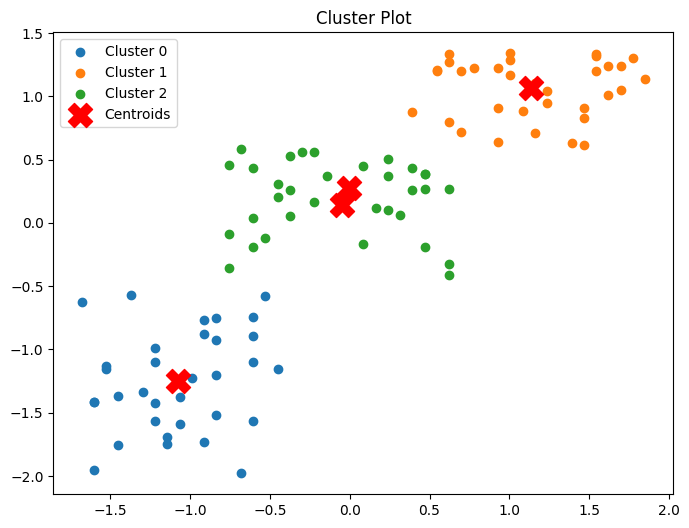

In [232]:
# Create the figure
plt.figure(figsize=(8, 6))

# Loop through the clusters
for cluster_num in range(3):
    mask = df['cluster'] == cluster_num
    plt.scatter(df_scaled[mask].iloc[:, 0], df_scaled[mask].iloc[:, 1], label=f'Cluster {cluster_num}')

# Plot the centroids
plt.scatter(modelo_kmeans.cluster_centers_[:, 0],
            modelo_kmeans.cluster_centers_[:, 1],
            s=300,
            c='red',
            marker='X',
            label='Centroids')
plt.legend()
plt.title("Cluster Plot")
plt.show()

See how many observations were assigned to each cluster to understand their size.

In [233]:
df['cluster'].value_counts()

,count
cluster,
2,33
0,33
1,33


### **Silhouette Analysis**
A useful metric to evaluate the quality of clusters is the silhouette analysis. Values closer to 1 indicate that the data points are very similar to other points within the same cluster and very different from points in other clusters. Negative values indicate that the data points may have been grouped into the wrong cluster.

In [234]:
df.groupby('cluster').mean()

,Age,Monthly_Spending,Subscription_Duration,Usage_Rate,Support_Tickets,Cancelled
cluster,,,,,,
0,25.848485,302.863443,5.606061,0.293108,0.787879,0.030303
1,54.848485,923.899857,20.484848,0.897401,2.272727,0.909091
2,38.969697,690.449726,14.848485,0.622612,2.181818,0.545455


In [235]:
score = silhouette_score(df_scaled, df['cluster'])
print(score)

0.41846445080765354


### **2D Scatter Plot (For 2 Features)**

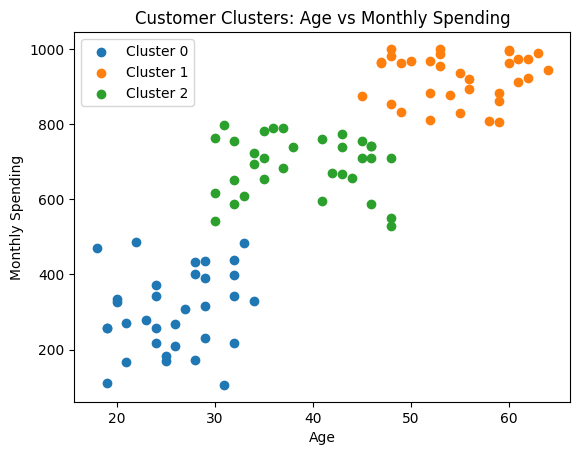

In [236]:
import matplotlib.pyplot as plt

# Plot
plt.scatter(df[df['cluster'] == 0]['Age'], df[df['cluster'] == 0]['Monthly_Spending'], label='Cluster 0')
plt.scatter(df[df['cluster'] == 1]['Age'], df[df['cluster'] == 1]['Monthly_Spending'], label='Cluster 1')
plt.scatter(df[df['cluster'] == 2]['Age'], df[df['cluster'] == 2]['Monthly_Spending'], label='Cluster 2')

# Adding title and labels
plt.title('Customer Clusters: Age vs Monthly Spending')
plt.xlabel('Age')
plt.ylabel('Monthly Spending')
plt.legend()

# Displaying the plot
plt.show()

### **3D Scatter Plot (For 3 Features)**

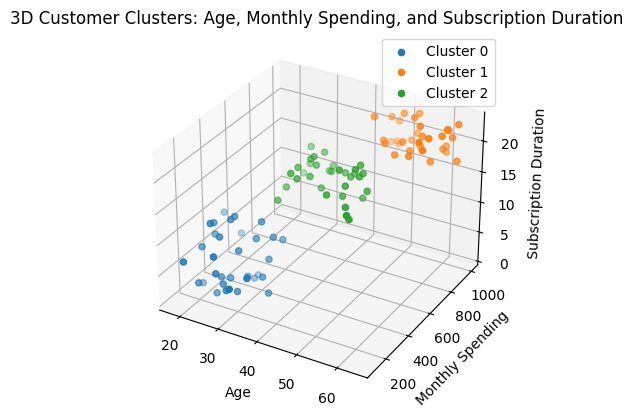

In [237]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Create the figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot
ax.scatter(df[df['cluster'] == 0]['Age'], df[df['cluster'] == 0]['Monthly_Spending'], df[df['cluster'] == 0]['Subscription_Duration'], label='Cluster 0')
ax.scatter(df[df['cluster'] == 1]['Age'], df[df['cluster'] == 1]['Monthly_Spending'], df[df['cluster'] == 1]['Subscription_Duration'], label='Cluster 1')
ax.scatter(df[df['cluster'] == 2]['Age'], df[df['cluster'] == 2]['Monthly_Spending'], df[df['cluster'] == 2]['Subscription_Duration'], label='Cluster 2')

# Adding labels and title
ax.set_xlabel('Age')
ax.set_ylabel('Monthly Spending')
ax.set_zlabel('Subscription Duration')
ax.set_title('3D Customer Clusters: Age, Monthly Spending, and Subscription Duration')

# Display legend and show plot
ax.legend()
plt.show()

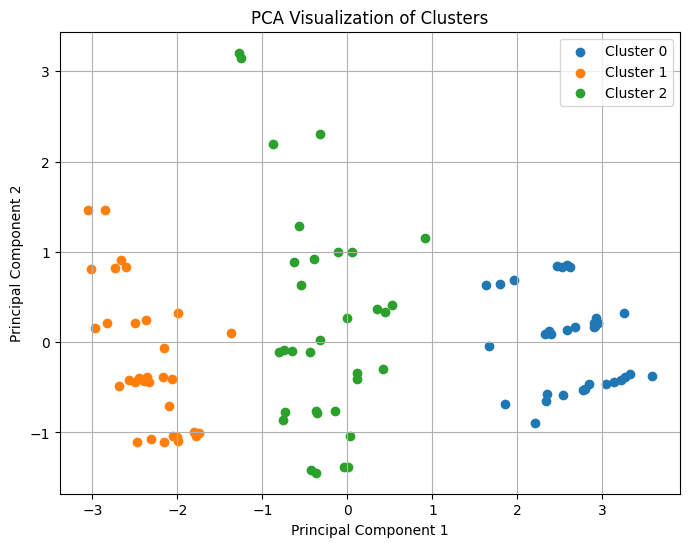

In [238]:
# Visualization with PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Create the PCA model with 2 principal components
pca = PCA(n_components=2)

# Train the model using scaled data
principalComponents = pca.fit_transform(df_scaled)

# Create the dataframe with the results
df_principal = pd.DataFrame(data=principalComponents, columns=['PC 1', 'PC 2'])
df_principal['cluster'] = df['cluster']

# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(df_principal[df_principal['cluster'] == 0]['PC 1'], df_principal[df_principal['cluster'] == 0]['PC 2'], label='Cluster 0')
plt.scatter(df_principal[df_principal['cluster'] == 1]['PC 1'], df_principal[df_principal['cluster'] == 1]['PC 2'], label='Cluster 1')
plt.scatter(df_principal[df_principal['cluster'] == 2]['PC 1'], df_principal[df_principal['cluster'] == 2]['PC 2'], label='Cluster 2')

# Customizations
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Clusters')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

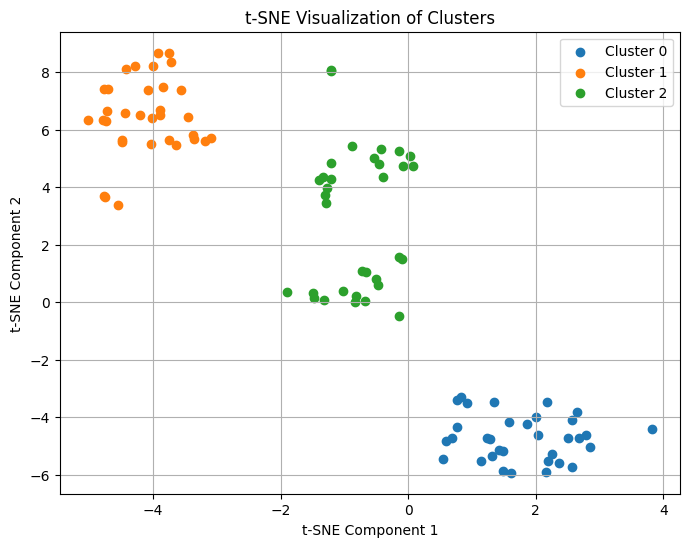

In [239]:
# Visualization with t-SNE (t-distributed Stochastic Neighbor Embedding)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

# t-SNE model with 2 components
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(df_scaled)

# Creating a dataframe for t-SNE results
df_tsne = pd.DataFrame(data=tsne_results, columns=['tsne 1', 'tsne 2'])
df_tsne['cluster'] = df['cluster']

# Plotting the t-SNE results
plt.figure(figsize=(8, 6))
plt.scatter(df_tsne[df_tsne['cluster'] == 0]['tsne 1'], df_tsne[df_tsne['cluster'] == 0]['tsne 2'], label='Cluster 0')
plt.scatter(df_tsne[df_tsne['cluster'] == 1]['tsne 1'], df_tsne[df_tsne['cluster'] == 1]['tsne 2'], label='Cluster 1')
plt.scatter(df_tsne[df_tsne['cluster'] == 2]['tsne 1'], df_tsne[df_tsne['cluster'] == 2]['tsne 2'], label='Cluster 2')

# Customizations
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Clusters')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Cluster Plot

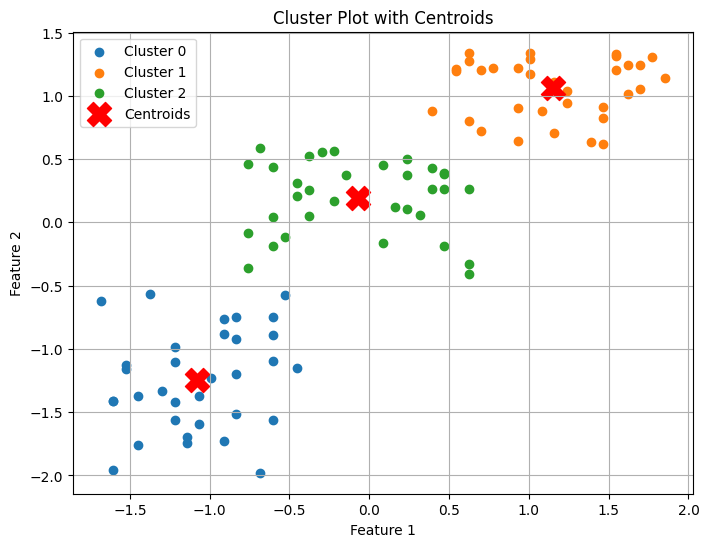

In [240]:
# Create the figure
plt.figure(figsize=(8, 6))

# Loop through clusters
for cluster_num in range(3):
    mask = df['cluster'] == cluster_num
    plt.scatter(df_scaled[mask].iloc[:, 0], df_scaled[mask].iloc[:, 1], label=f'Cluster {cluster_num}')

# Plot the centroids
plt.scatter(model_kmeans.cluster_centers_[:, 0],
            model_kmeans.cluster_centers_[:, 1],
            s=300,
            c='red',
            marker='X',
            label='Centroids')

# Customizations
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Cluster Plot with Centroids')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

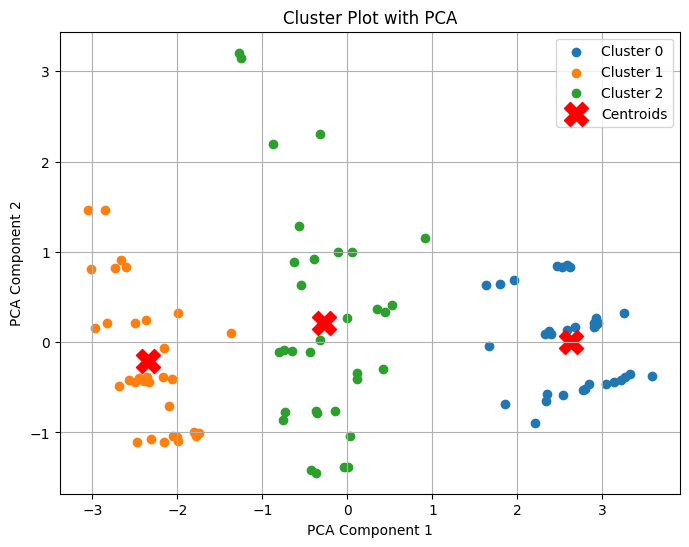

In [241]:
# Import necessary libraries
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce the dimensions to 2
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

# Store the PCA results in the dataframe
df['pca_1'] = pca_result[:, 0]
df['pca_2'] = pca_result[:, 1]

# Create the figure
plt.figure(figsize=(8, 6))

# Loop through clusters and plot each one
for cluster_num in range(3):
    mask = df['cluster'] == cluster_num
    plt.scatter(df[mask]['pca_1'], df[mask]['pca_2'], label=f'Cluster {cluster_num}')

# Get the transformed centroids for visualization
centroids_pca = pca.transform(model_kmeans.cluster_centers_)
plt.scatter(centroids_pca[:, 0],
            centroids_pca[:, 1],
            s=300,
            c='red',
            marker='X',
            label='Centroids')

# Customizations
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Cluster Plot with PCA')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [242]:
%reload_ext watermark
%watermark -a "@panData"


Author: @panData



In [243]:
#%watermark -v -m

In [244]:
#%watermark --iversions

# **The End**